<a href="https://colab.research.google.com/github/robertej19/nflows/blob/master/NewMoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/robertej19/nflows.git

Cloning into 'nflows'...
remote: Enumerating objects: 1163, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1163 (delta 2), reused 6 (delta 1), pack-reused 1141
Receiving objects: 100% (1163/1163), 1.66 MiB | 4.67 MiB/s, done.
Resolving deltas: 100% (748/748), done.


In [1]:
import sys
sys.path.insert(0,'/mnt/c/Users/rober/Dropbox/Bobby/Linux/classes/GAML/GAMLX/nflows/nflows')


In [2]:
from nflows.transforms.autoregressive import MaskedUMNNAutoregressiveTransform

In [13]:

#copy files from dropbox 
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-05-07 19:32:35--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-05-07 19:32:35--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc8a05678ddba6c9ac78d685d8d.dl.dropboxusercontent.com/cd/0/inline/BOE0oYltvX1MM8dj8Zh9dwTAV9Pz8HTHwJCpMxZy2uhhszTctLvMdFmQL2FNldc2lVNaimtNSUUz3_VAmazbpVq9b5cv0LLK4Y4CEG1uderi8q6nO9p2xLevABSuJchTBEJ6g-VjrDu4qU2gR0VNG7yG/file# [following]
--2021-05-07 19:32:35--  https://ucc8a05678ddba6c9ac78d685d8d.dl.dropboxusercontent.com/cd/0/inline/BOE0oYltvX1MM8dj8Zh9dwTAV9Pz8HTHwJCpMxZy2uhhszTctLvMdFmQL2FNldc2lVNaimtNSUUz3_VAmazbpVq9b5cv0LLK4Y4C

In [3]:
import sys
sys.path.insert(0,'/content/nflows/nflows')

In [4]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [16]:
!pip install nflows

  Using cached https://files.pythonhosted.org/packages/bd/16/a484db41aab28332f42080435c9342fa87cfc9a4fce5495521ea1e80ca27/nflows-0.14.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-8ortgD/nflows/setup.py", line 7, in <module>
        with open(path.join(this_directory, 'README.md'), encoding='utf-8') as f:
    TypeError: 'encoding' is an invalid keyword argument for this function
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-8ortgD/nflows/


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.datasets as datasets
import itertools
import numpy as np
%matplotlib inline
from datetime import datetime
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial import distance


import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.normal import DiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [5]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        #xz = xz[:, 1:]
        z = xz[:, 16:]
        x = cartesian_converter(xz)
        #x = x[:, [0,4,8,12]]
        x = x[:, [1,2,3,4]]
        #x = xz[:, :16]
        #xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        #xwithoutPid = x[:, [0,  4, 8, 12, ]]
        xwithoutPid = x
        #xwithoutPid = x[:, [0, 1, 4, 5, 8, 12, ]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [ ]:
xz = dataXZ()
z = xz.z
x = xz.x

In [8]:
#returns an nx16 array, of energy, px, py, pz, for electron, proton, g1, g2
#You should just pass it the xz object from the dataXZ() class
def cartesian_converter(xznp):
  #split into electron, proton, gammas
  e_vec = xznp[:,1:5]
  p_vec = xznp[:,5:9]
  g1_vec = xznp[:,9:13]
  g2_vec = xznp[:,13:17]

  mass_e = .000511
  mass_p = 0.938
  mass_g = 0

  particles = [e_vec,p_vec,g1_vec,g2_vec]
  masses = [mass_e,mass_p,mass_g,mass_g]

  parts_new = []
  #convert from spherical to cartesian
  for part_vec, mass in zip(particles,masses):
    mom = part_vec[:,0]
    thet = part_vec[:,1]*np.pi/180
    phi = part_vec[:,2]*np.pi/180

    pz = mom*np.cos(thet)
    px = mom*np.sin(thet)*np.cos(phi)
    py = mom*np.sin(thet)*np.sin(phi)
    p2 = pz*pz+px*px+py*py
    E = np.sqrt(mass**2+p2)
    
    x_new = np.array([E,px,py,pz])
    parts_new.append(x_new)

  #reshape output into 1x16 arrays for each event
  e = parts_new[0]
  p = parts_new[1]
  g1 = parts_new[2]
  g2 = parts_new[3]
  out = np.concatenate((e.T,p.T,g1.T,g2.T), axis=1)

  return out

In [10]:
sampleDict = xz.sample(2) 
print(sampleDict["x"])

tensor([[3.7363, 0.4562, 3.9259, 2.7814],
        [4.4506, 0.5240, 3.2318, 2.0101]])


In [23]:
sampleDict = xz.sample(100000) #Get a subset of the datapoints
x = sampleDict["x"]
x= x.detach().numpy()

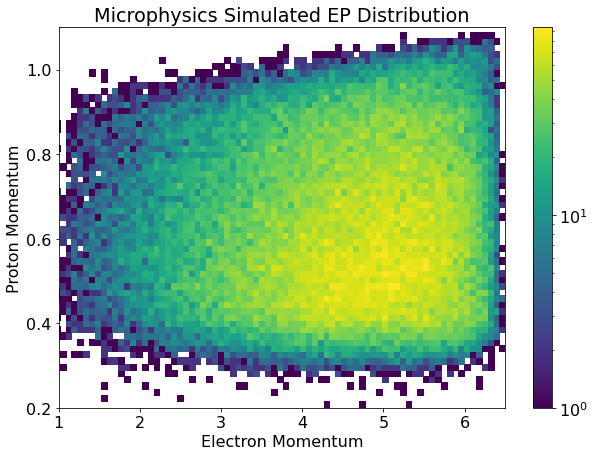

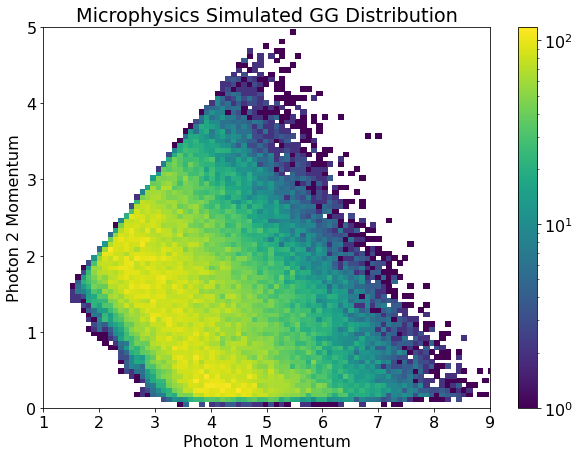

In [24]:

bin_size = [80,80]
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Proton Momentum")
plt.title('Microphysics Simulated EP Distribution')

plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,6.5])
plt.ylim([0.2,1.1])
plt.colorbar()



fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Photon 1 Momentum")  
ax.set_ylabel("Photon 2 Momentum")
plt.title('Microphysics Simulated GG Distribution')
plt.hist2d(x[:,2], x[:,3],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,9])
plt.ylim([0,5])
plt.colorbar()


In [ ]:
#x, y = datasets.make_moons(1208, noise=.1)
#plt.scatter(x[:, 0], x[:, 1]);

In [67]:
num_layers = 10#12
base_dist = StandardNormal(shape=[4])
#base_dist = DiagonalNormal(shape=[3])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=4))
    transforms.append(MaskedAffineAutoregressiveTransform(features=4, 
                                                          hidden_features=20))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())
print("number of params: ", sum(p.numel() for p in flow.parameters()))

number of params:  19480


In [68]:
sampleDict = xz.sample(1)
x = sampleDict["x"][:,:]
print(x)

tensor([[4.4974, 0.4021, 4.3707, 0.8012]])


In [69]:
def plot_histo_1D(real_vals, gen_vals, label_real="Physics Data", label_gen="NFlow Model", col2 = "blue",title="Physics vs NFlow Models", saveloc=None):
    fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
    for INDEX, ax in zip((0, 1, 2,3 ), axes):
        _, bins, _ = ax.hist(real_vals[:, INDEX], bins=100, color = "red", label=label_real, density=True)
        ax.hist(gen_vals[:, INDEX], bins=bins, label=label_gen, color = col2,alpha=0.5, density=True)
        ax.legend(loc="lower left")
        ax.set_title("Feature {}".format(INDEX) )
    plt.tight_layout()
    if saveloc is not None: plt.savefig(saveloc)
    plt.show()

def meter(dist1,dist2,feature):
  kld = entropy(dist1[:,feature],dist2[:,feature])
  emd = wasserstein_distance(dist1[:,feature],dist2[:,feature])
  jsd = distance.jensenshannon(dist1[:,feature],dist2[:,feature]) ** 2
  return [kld, emd, jsd]

Start Time = 19:00:11


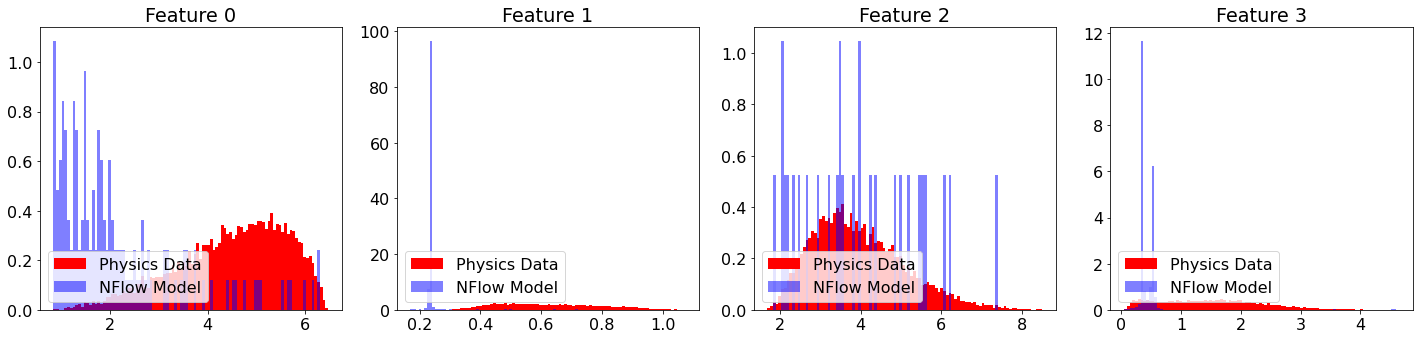

On step 0 - loss 19.60, Current Running Time = 0.04 seconds
KL Divergence Values: F0: inf  F1: inf  F2: inf 
EM Distance   Values: F0: 7692180649479.07617  F1: 445096733357469.93750  F2: 16270024566574.71094 


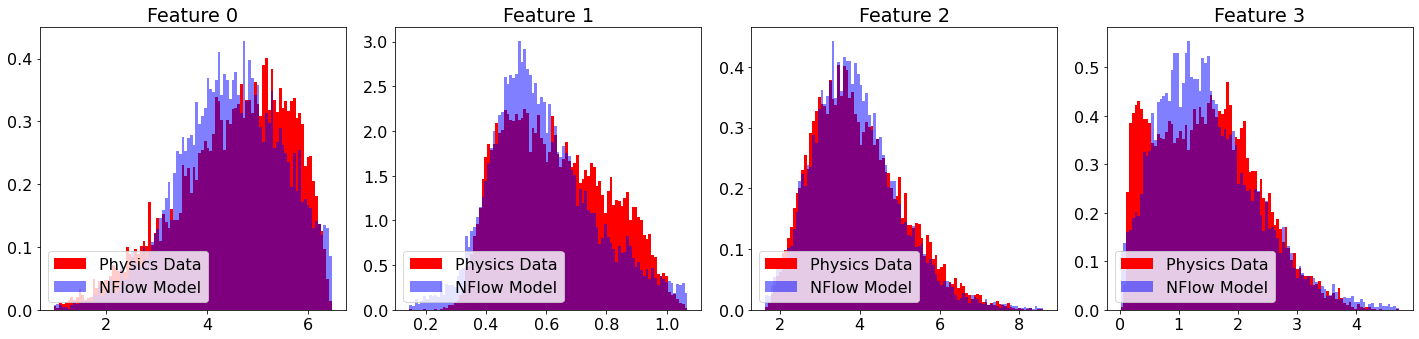

On step 100 - loss 2.86, Current Running Time = 11.61 seconds
KL Divergence Values: F0: inf  F1: inf  F2: inf 
EM Distance   Values: F0: 0.17201  F1: 227586.54944  F2: 3635.06496 
On step 110 - loss 2.72, Current Running Time = 17.55 seconds
EM Distance   Values: F0: 0.17842  F1: 0.04069  F2: 0.09265 F3: 0.07070 
On step 120 - loss 2.75, Current Running Time = 18.14 seconds
EM Distance   Values: F0: 0.18569  F1: 0.04622  F2: 0.09517 F3: 0.07300 
On step 130 - loss 2.61, Current Running Time = 18.82 seconds
EM Distance   Values: F0: 0.19660  F1: 0.02910  F2: 0.11122 F3: 0.06670 
On step 140 - loss 2.60, Current Running Time = 19.41 seconds
EM Distance   Values: F0: 0.17961  F1: 0.03251  F2: 0.14423 F3: 0.06527 
On step 150 - loss 2.60, Current Running Time = 20.02 seconds
EM Distance   Values: F0: 0.16098  F1: 0.03612  F2: 0.13835 F3: 0.06994 
On step 160 - loss 2.62, Current Running Time = 20.63 seconds
EM Distance   Values: F0: 0.19842  F1: 0.02410  F2: 0.09898 F3: 0.05575 
On step 17

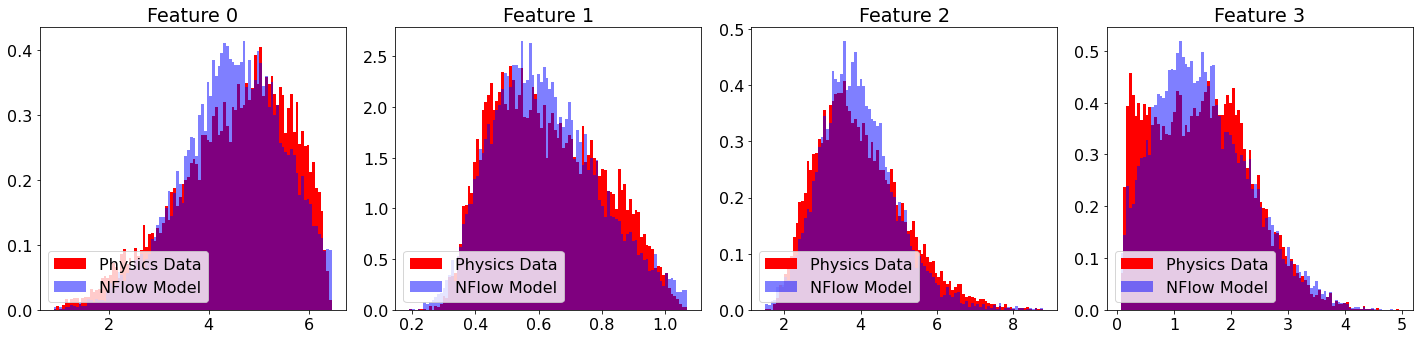

On step 200 - loss 2.51, Current Running Time = 23.14 seconds
KL Divergence Values: F0: inf  F1: 0.07754  F2: 0.07269 
EM Distance   Values: F0: 0.13238  F1: 0.01618  F2: 0.12807 
On step 210 - loss 2.51, Current Running Time = 29.06 seconds
EM Distance   Values: F0: 0.15868  F1: 0.01714  F2: 0.10883 F3: 0.05445 
On step 220 - loss 2.52, Current Running Time = 29.66 seconds
EM Distance   Values: F0: 0.12856  F1: 0.01745  F2: 0.10043 F3: 0.08109 
On step 230 - loss 2.40, Current Running Time = 30.25 seconds
EM Distance   Values: F0: 0.13206  F1: 0.01821  F2: 0.11496 F3: 0.05414 
On step 240 - loss 2.35, Current Running Time = 30.86 seconds
EM Distance   Values: F0: 0.15027  F1: 0.01596  F2: 0.09466 F3: 0.05952 
On step 250 - loss 2.45, Current Running Time = 31.50 seconds
EM Distance   Values: F0: 0.14234  F1: 0.01567  F2: 0.12561 F3: 0.06362 
On step 260 - loss 2.46, Current Running Time = 32.10 seconds
EM Distance   Values: F0: 0.10677  F1: 0.02495  F2: 0.08717 F3: 0.05366 
On step 27

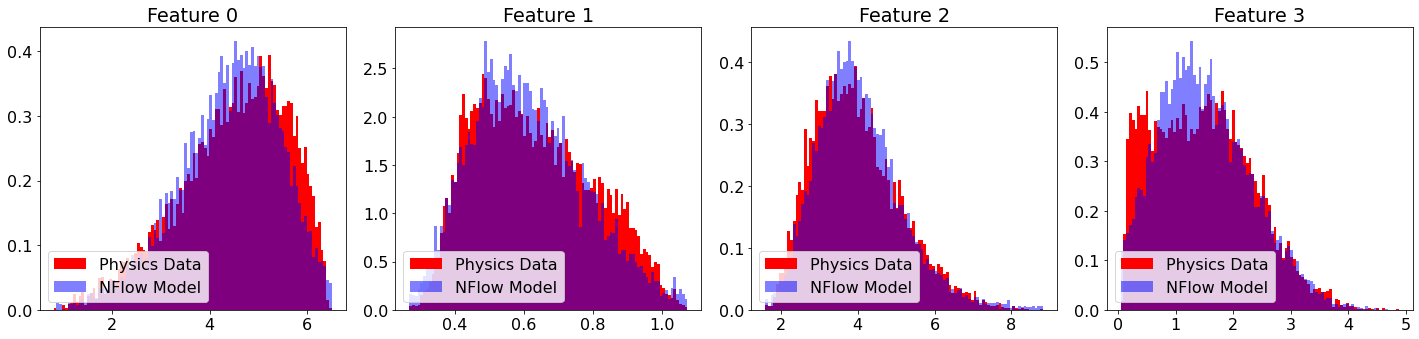

On step 300 - loss 2.42, Current Running Time = 34.50 seconds
KL Divergence Values: F0: inf  F1: 0.07432  F2: 0.07630 
EM Distance   Values: F0: 0.10568  F1: 0.01743  F2: 0.08886 
On step 310 - loss 2.33, Current Running Time = 40.47 seconds
EM Distance   Values: F0: 0.10190  F1: 0.01493  F2: 0.10962 F3: 0.06437 
On step 320 - loss 2.28, Current Running Time = 41.08 seconds
EM Distance   Values: F0: 0.08441  F1: 0.01470  F2: 0.14595 F3: 0.06560 
On step 330 - loss 2.37, Current Running Time = 41.68 seconds
EM Distance   Values: F0: 0.08890  F1: 0.01461  F2: 0.15882 F3: 0.06743 
On step 340 - loss 2.26, Current Running Time = 42.28 seconds
EM Distance   Values: F0: 0.07353  F1: 0.01214  F2: 0.08982 F3: 0.07636 
On step 350 - loss 2.38, Current Running Time = 42.89 seconds
EM Distance   Values: F0: 0.06824  F1: 0.01196  F2: 0.09036 F3: 0.06221 
On step 360 - loss 2.27, Current Running Time = 43.51 seconds
EM Distance   Values: F0: 0.10132  F1: 0.01629  F2: 0.08366 F3: 0.05867 
On step 37

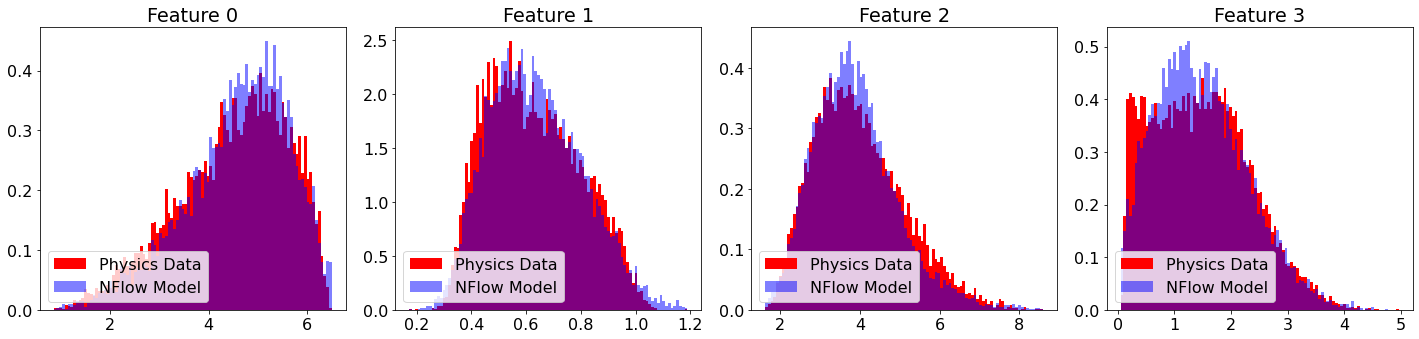

On step 400 - loss 2.27, Current Running Time = 45.97 seconds
KL Divergence Values: F0: inf  F1: 0.07180  F2: 0.07784 
EM Distance   Values: F0: 0.12919  F1: 0.01078  F2: 0.11509 
On step 410 - loss 2.31, Current Running Time = 51.90 seconds
EM Distance   Values: F0: 0.08571  F1: 0.02759  F2: 0.07397 F3: 0.07204 
On step 420 - loss 2.25, Current Running Time = 52.52 seconds
EM Distance   Values: F0: 0.04188  F1: 0.01654  F2: 0.15347 F3: 0.06266 
On step 430 - loss 2.23, Current Running Time = 53.14 seconds
EM Distance   Values: F0: 0.15869  F1: 0.01144  F2: 0.18984 F3: 0.03540 
On step 440 - loss 2.30, Current Running Time = 53.75 seconds
EM Distance   Values: F0: 0.08317  F1: 0.01197  F2: 0.07159 F3: 0.04060 
On step 450 - loss 2.26, Current Running Time = 54.39 seconds
EM Distance   Values: F0: 0.05943  F1: 0.01002  F2: 0.07397 F3: 0.06676 
On step 460 - loss 2.25, Current Running Time = 54.99 seconds
EM Distance   Values: F0: 0.08053  F1: 0.01395  F2: 0.12654 F3: 0.03706 
On step 47

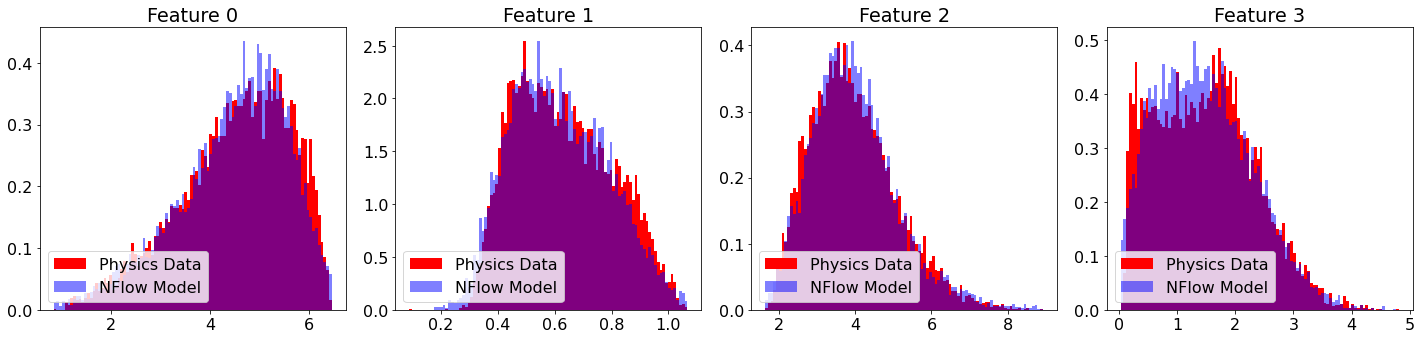

On step 500 - loss 2.22, Current Running Time = 57.50 seconds
KL Divergence Values: F0: inf  F1: 0.07635  F2: 0.08047 
EM Distance   Values: F0: 0.05197  F1: 0.01308  F2: 0.05495 
On step 510 - loss 2.22, Current Running Time = 63.57 seconds
EM Distance   Values: F0: 0.05914  F1: 0.00839  F2: 0.06179 F3: 0.04579 
On step 520 - loss 2.20, Current Running Time = 64.16 seconds
EM Distance   Values: F0: 0.07112  F1: 0.01155  F2: 0.07356 F3: 0.03314 
On step 530 - loss 2.26, Current Running Time = 64.86 seconds
EM Distance   Values: F0: 0.06997  F1: 0.01411  F2: 0.06617 F3: 0.03628 
On step 540 - loss 2.24, Current Running Time = 65.51 seconds
EM Distance   Values: F0: 0.05184  F1: 0.00683  F2: 0.05558 F3: 0.03122 
On step 550 - loss 2.24, Current Running Time = 66.14 seconds
EM Distance   Values: F0: 0.12394  F1: 0.01004  F2: 0.19741 F3: 0.04157 
On step 560 - loss 2.30, Current Running Time = 66.74 seconds
EM Distance   Values: F0: 0.13228  F1: 0.01076  F2: 0.12988 F3: 0.03194 
On step 57

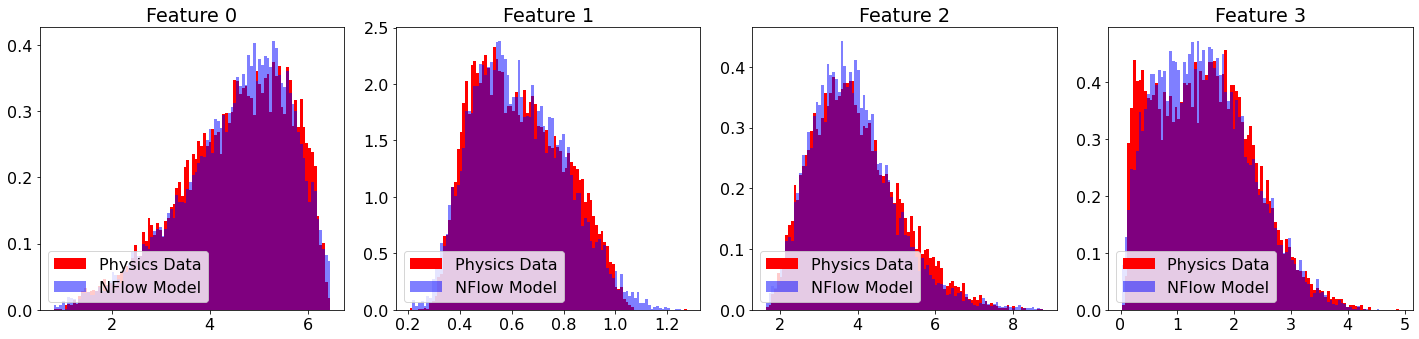

On step 600 - loss 2.18, Current Running Time = 69.18 seconds
KL Divergence Values: F0: inf  F1: 0.07508  F2: 0.07821 
EM Distance   Values: F0: 0.05964  F1: 0.00782  F2: 0.09652 
On step 610 - loss 2.25, Current Running Time = 75.17 seconds
EM Distance   Values: F0: 0.13591  F1: 0.00885  F2: 0.10774 F3: 0.03280 
On step 620 - loss 2.27, Current Running Time = 75.88 seconds
EM Distance   Values: F0: 0.10246  F1: 0.00838  F2: 0.06366 F3: 0.02897 
On step 630 - loss 2.23, Current Running Time = 76.52 seconds
EM Distance   Values: F0: 0.04177  F1: 0.01120  F2: 0.05139 F3: 0.05828 
On step 640 - loss 2.25, Current Running Time = 77.10 seconds
EM Distance   Values: F0: 0.17733  F1: 0.00847  F2: 0.06593 F3: 0.04465 
On step 650 - loss 2.27, Current Running Time = 77.78 seconds
EM Distance   Values: F0: 0.07039  F1: 0.00698  F2: 0.15166 F3: 0.02573 
On step 660 - loss 2.36, Current Running Time = 78.38 seconds
EM Distance   Values: F0: 0.07960  F1: 0.00965  F2: 0.08173 F3: 0.02467 
On step 67

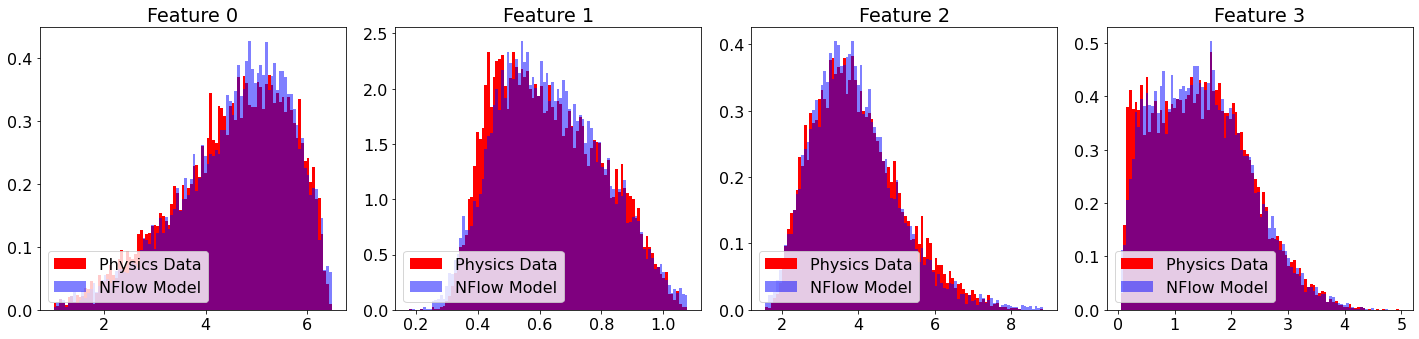

On step 700 - loss 2.22, Current Running Time = 80.82 seconds
KL Divergence Values: F0: inf  F1: 0.07254  F2: 0.08098 
EM Distance   Values: F0: 0.09060  F1: 0.01002  F2: 0.07459 
On step 710 - loss 2.18, Current Running Time = 86.77 seconds
EM Distance   Values: F0: 0.03189  F1: 0.00998  F2: 0.05962 F3: 0.03843 
On step 720 - loss 2.26, Current Running Time = 87.40 seconds
EM Distance   Values: F0: 0.04905  F1: 0.00746  F2: 0.03787 F3: 0.05983 
On step 730 - loss 2.22, Current Running Time = 88.02 seconds
EM Distance   Values: F0: 0.11496  F1: 0.00791  F2: 0.08570 F3: 0.01733 
On step 740 - loss 2.25, Current Running Time = 88.61 seconds
EM Distance   Values: F0: 0.07228  F1: 0.00987  F2: 0.05313 F3: 0.02201 
On step 750 - loss 2.23, Current Running Time = 89.20 seconds
EM Distance   Values: F0: 0.09078  F1: 0.01012  F2: 0.08619 F3: 0.02868 
On step 760 - loss 2.24, Current Running Time = 89.80 seconds
EM Distance   Values: F0: 0.05792  F1: 0.00661  F2: 0.04394 F3: 0.03691 
On step 77

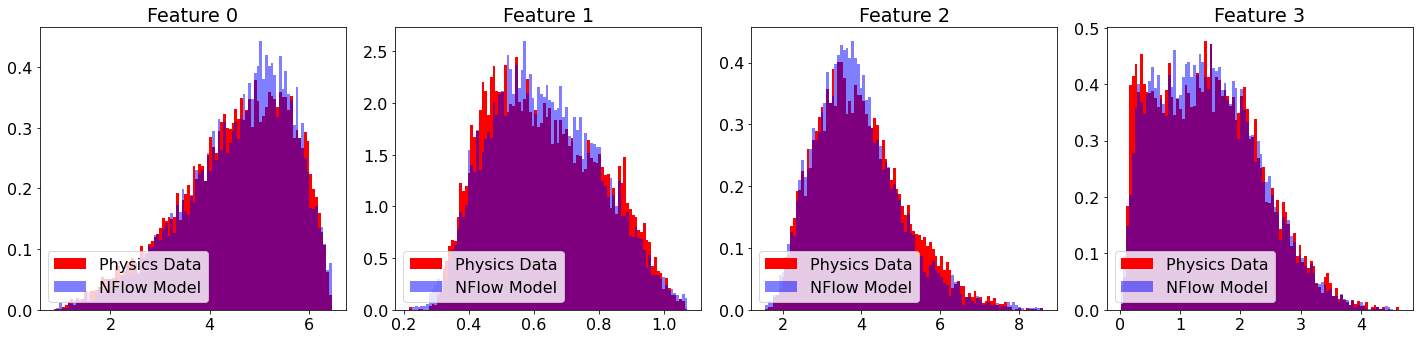

On step 800 - loss 2.24, Current Running Time = 92.17 seconds
KL Divergence Values: F0: inf  F1: 0.07200  F2: 0.07759 
EM Distance   Values: F0: 0.09057  F1: 0.01012  F2: 0.10401 
On step 810 - loss 2.23, Current Running Time = 98.11 seconds
EM Distance   Values: F0: 0.05949  F1: 0.00563  F2: 0.05880 F3: 0.02679 
On step 820 - loss 2.19, Current Running Time = 98.70 seconds
EM Distance   Values: F0: 0.09424  F1: 0.01150  F2: 0.11138 F3: 0.03152 
On step 830 - loss 2.20, Current Running Time = 99.31 seconds
EM Distance   Values: F0: 0.04109  F1: 0.00745  F2: 0.04828 F3: 0.04109 
On step 840 - loss 2.20, Current Running Time = 99.93 seconds
EM Distance   Values: F0: 0.12574  F1: 0.01216  F2: 0.12004 F3: 0.01792 
On step 850 - loss 2.16, Current Running Time = 100.53 seconds
EM Distance   Values: F0: 0.03219  F1: 0.00919  F2: 0.09695 F3: 0.02688 
On step 860 - loss 2.18, Current Running Time = 101.13 seconds
EM Distance   Values: F0: 0.02938  F1: 0.00433  F2: 0.06925 F3: 0.01905 
On step 

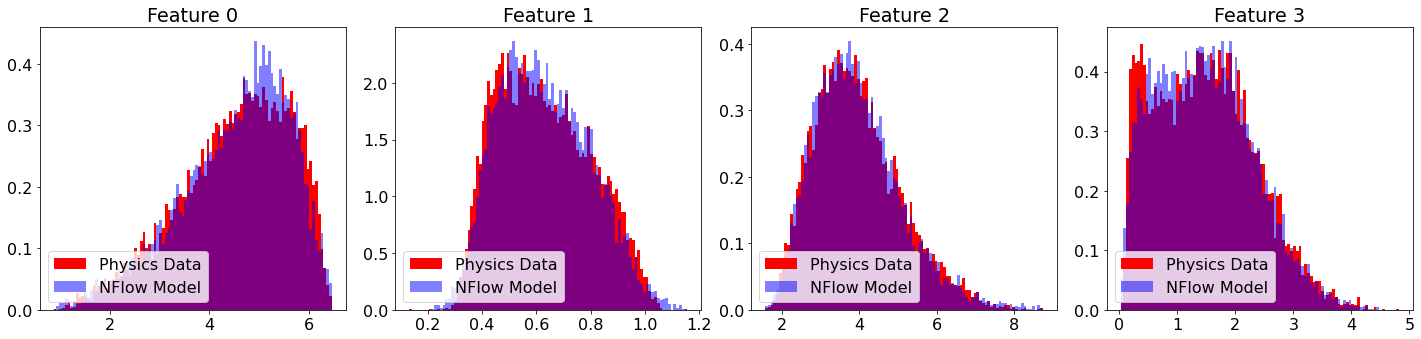

On step 900 - loss 2.20, Current Running Time = 103.57 seconds
KL Divergence Values: F0: inf  F1: 0.07347  F2: 0.07934 
EM Distance   Values: F0: 0.03905  F1: 0.00809  F2: 0.02862 
On step 910 - loss 2.21, Current Running Time = 109.64 seconds
EM Distance   Values: F0: 0.08555  F1: 0.00982  F2: 0.10280 F3: 0.04263 
On step 920 - loss 2.22, Current Running Time = 110.24 seconds
EM Distance   Values: F0: 0.06331  F1: 0.01050  F2: 0.06433 F3: 0.02447 
On step 930 - loss 2.26, Current Running Time = 110.84 seconds
EM Distance   Values: F0: 0.06828  F1: 0.00781  F2: 0.08185 F3: 0.01693 
On step 940 - loss 2.23, Current Running Time = 111.47 seconds
EM Distance   Values: F0: 0.03910  F1: 0.00804  F2: 0.04807 F3: 0.01941 
On step 950 - loss 2.17, Current Running Time = 112.08 seconds
EM Distance   Values: F0: 0.05048  F1: 0.00775  F2: 0.04848 F3: 0.01567 
On step 960 - loss 2.14, Current Running Time = 112.72 seconds
EM Distance   Values: F0: 0.06954  F1: 0.01019  F2: 0.06199 F3: 0.01879 
On 

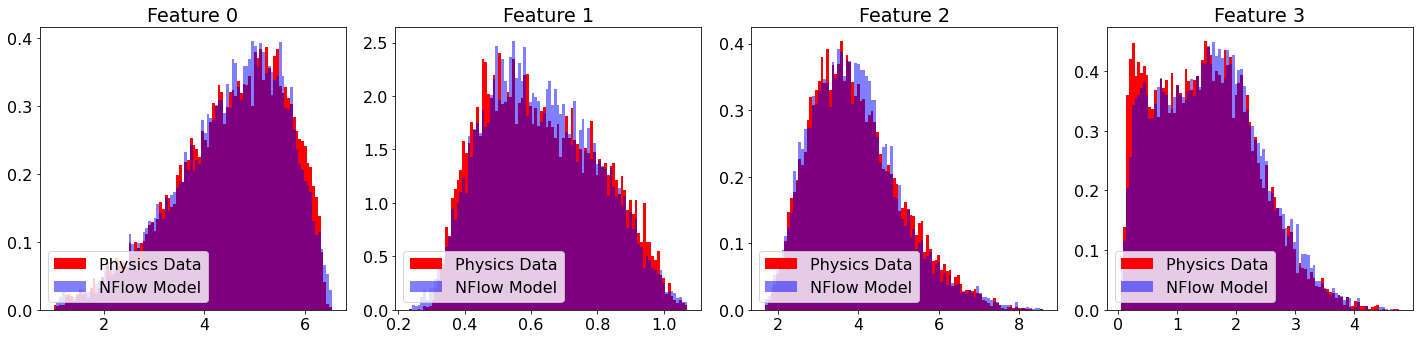

On step 1000 - loss 2.22, Current Running Time = 115.15 seconds
KL Divergence Values: F0: inf  F1: 0.07381  F2: 0.08062 
EM Distance   Values: F0: 0.02974  F1: 0.00811  F2: 0.04855 
On step 1010 - loss 2.18, Current Running Time = 121.04 seconds
EM Distance   Values: F0: 0.04270  F1: 0.00685  F2: 0.04732 F3: 0.02298 
On step 1020 - loss 2.28, Current Running Time = 121.64 seconds
EM Distance   Values: F0: 0.06357  F1: 0.00551  F2: 0.04640 F3: 0.03956 
On step 1030 - loss 2.25, Current Running Time = 122.24 seconds
EM Distance   Values: F0: 0.05698  F1: 0.00955  F2: 0.04586 F3: 0.03131 
On step 1040 - loss 2.12, Current Running Time = 122.84 seconds
EM Distance   Values: F0: 0.03703  F1: 0.00666  F2: 0.03801 F3: 0.03015 


KeyboardInterrupt: ignored

In [66]:
num_iter = 1000
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
f1_kd = []
f1_em = []
f1_js = []
f2_em = []
f3_em = []

for i in range(num_iter):
    # x, y = datasets.make_moons(12, noise=.1)
    # x = torch.tensor(x, dtype=torch.float32)
    # print(x)
    # print(y)
    sampleDict = xz.sample(1000)
    x = sampleDict["x"][:, 0:4] 
    #y = sampleDict["xwithoutPid"][:, 1:2] 
    #print(x)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())


    if i % 10 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        
        bbb = 10000
        z= flow.sample(bbb).detach().numpy()
        sampleDict = xz.sample(bbb)
        x = sampleDict["x"][:, 0:4] 
        x = x.detach().numpy()

        #plot_histo_1D(x,z)

        f1 = meter(x,z,0)
        f2 = meter(x,z,1)
        f3 = meter(x,z,2)
        f4 = meter(x,z,3)


        if f1[1]*f2[1]*f3[1]*f4[1] < 1:
          print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 
          print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1]),))
          #break

        f1_kd.append(f1[0])
        f1_em.append(f1[1])
        f1_js.append(f1[2])
        f2_em.append(f2[1])
        f3_em.append(f3[1])

        if i % 1000 == 0:
          bbb = 100000
          zzz= flow.sample(bbb).detach().numpy()
          sampleDictzz = xz.sample(bbb)
          x = sampleDict["x"]
          x = x.detach().numpy()
          plot_histo_1D(x,z)
          print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 
          print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[0]),(f2[0]),(f3[0]),))
          print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),))
        #print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),))


now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))
    # if (i + 1) % 50 == 0:
    #     xline = torch.linspace(-1.5, 2.5)
    #     yline = torch.linspace(-.75, 1.25)
    #     xgrid, ygrid = torch.meshgrid(xline, yline)
    #     xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    #     with torch.no_grad():
    #         zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

    #     plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    #     plt.title('iteration {}'.format(i + 1))
    #     plt.show()

Text(0, 0.5, 'Kullback–Leibler Divergence')

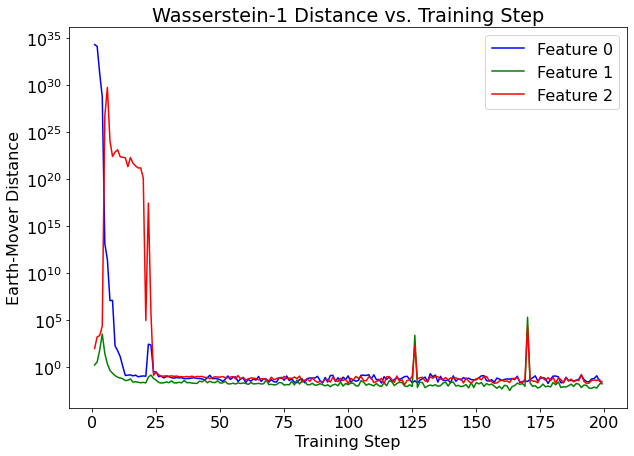

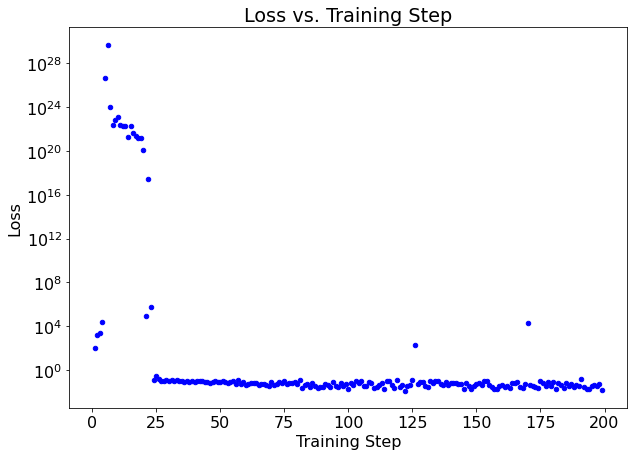

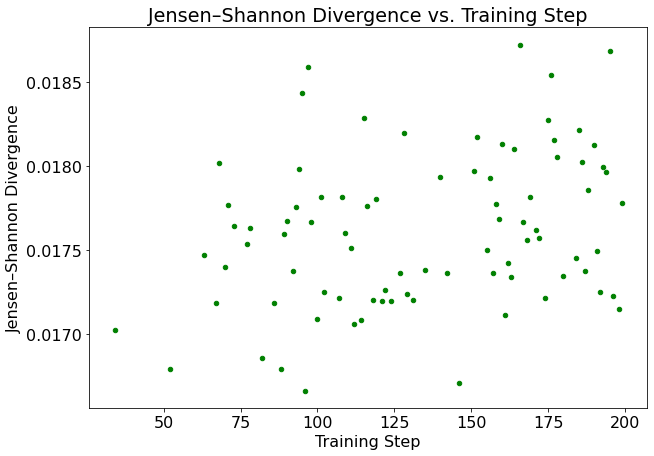

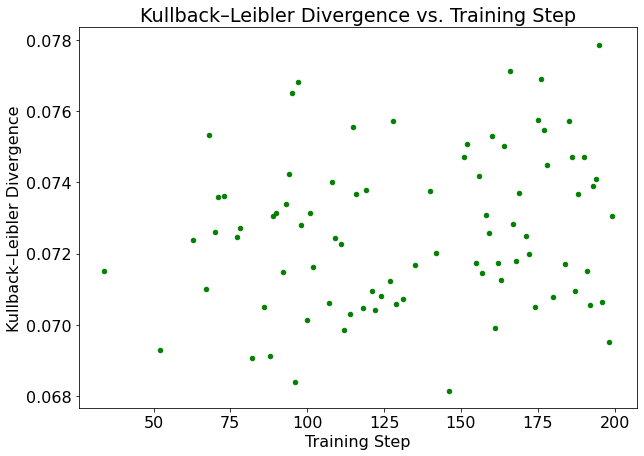

In [53]:
#f1_kd = []
#f1_em = []
#f1_js = []

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.plot(np.arange(len(f1_em)),f1_em, '-b',label="Feature 0")
plt.plot(np.arange(len(f1_em)),f2_em, '-g',label="Feature 1")
plt.plot(np.arange(len(f1_em)),f3_em, '-r',label="Feature 2")
#plt.ylim([1000000000,0.0001])
ax.set_yscale('log')
plt.title('Wasserstein-1 Distance vs. Training Step')
ax.legend()
ax.set_xlabel("Training Step")  
ax.set_ylabel("Earth-Mover Distance")


fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_em)),f3_em, c='b', s=20)
#plt.ylim([1000000000,0.0001])
ax.set_yscale('log')
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_js)),f1_js, c='g', s=20)
#plt.ylim([1000000000,0.0001])
#ax.set_yscale('log')
plt.title('Jensen–Shannon Divergence vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Jensen–Shannon Divergence")

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_kd)),f1_kd, c='g', s=20)
#plt.ylim([1000000000,0.0001])
#ax.set_yscale('log')
plt.title('Kullback–Leibler Divergence vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Kullback–Leibler Divergence")



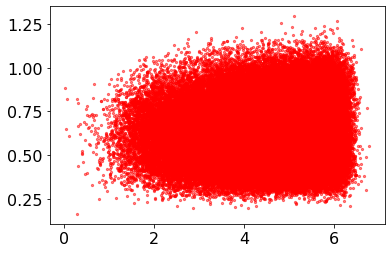

In [19]:
aa = flow.sample(100000).detach().numpy()

plt.scatter(aa[:,0], aa[:,1], c='r', s=5, alpha=0.5)

z = aa

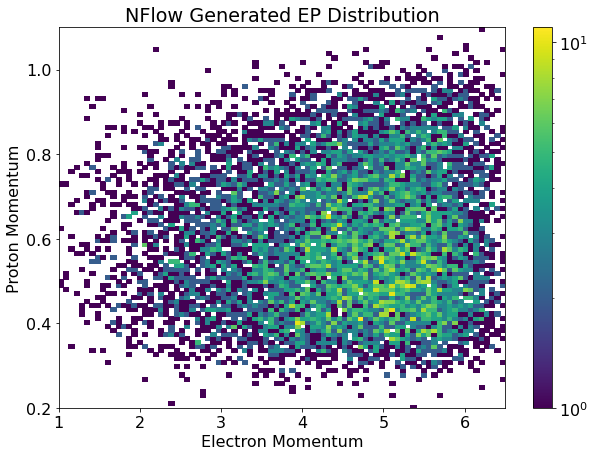

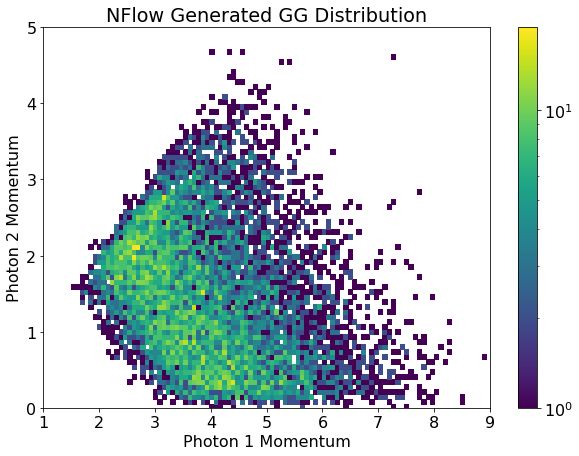

In [54]:


bin_size = [100,100]
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Proton Momentum")
plt.title('NFlow Generated EP Distribution')

plt.hist2d(z[:,0], z[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,6.5])
plt.ylim([0.2,1.1])
plt.colorbar()



fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Photon 1 Momentum")  
ax.set_ylabel("Photon 2 Momentum")
plt.title('NFlow Generated GG Distribution')
plt.hist2d(z[:,2], z[:,3],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,9])
plt.ylim([0,5])
plt.colorbar()





In [60]:
bbb = 100000
z= flow.sample(bbb).detach().numpy()
sampleDict = xz.sample(bbb)
sampleDict2 = xz.sample(bbb)
y = sampleDict2["x"]
y = y.detach().numpy()
x = sampleDict["x"]
x = x.detach().numpy()


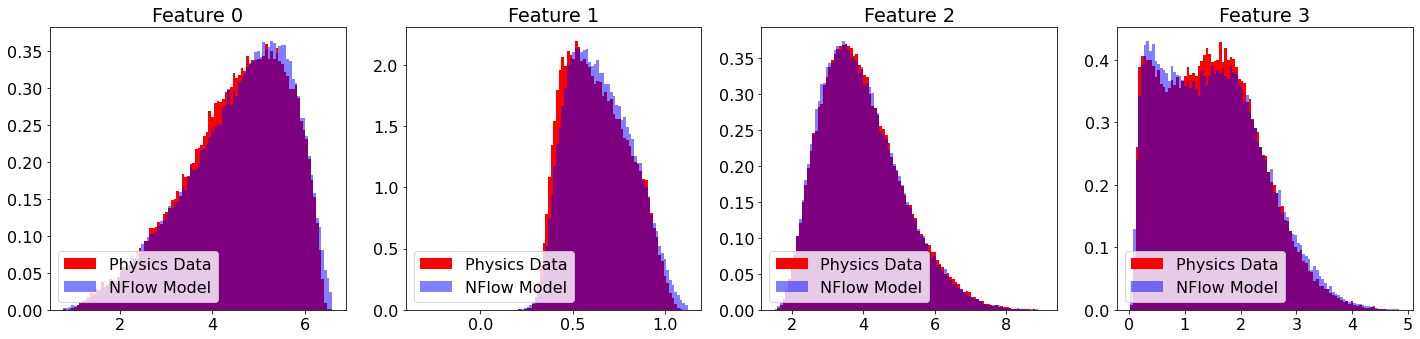

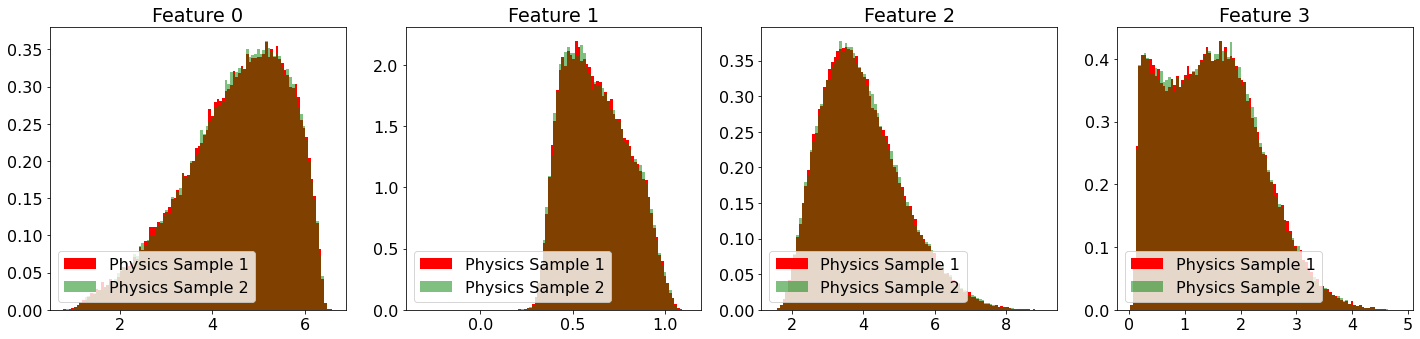

Values for Physics Data vs. NFlow Model:
KL Divergence Values: F0: inf  F1: inf  F2: 0.07939 ,F3: inf  
EM Distance   Values: F0: 0.05756  F1: 0.01942  F2: 0.02529 ,F3: 0.03254 
JS Divergence Values: F0: inf  F1: inf  F2: 0.01948  ,F3: inf 




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Ratio of KL, EM, and JS values from NFlow comparision and two physics model samples:
KL Divergence Ratio: F0: inf  F1: nan  F2: 1.00061 ,F3: inf  
EM Distance   Ratio: F0: 10.31500  F1: 20.06461  F2: 5.56716 ,F3: 8.05982 
JS Divergence Ratio: F0: inf  F1: nan  F2: 1.00004  ,F3: inf 


Values for two samples from physics data
KL Divergence Values: F0: 0.07171  F1: inf  F2: 0.07934 ,F3: 0.39252  
EM Distance   Values: F0: 0.00558  F1: 0.00097  F2: 0.00454 ,F3: 0.00404 
JS Divergence Values: F0: 0.01749  F1: inf  F2: 0.01948  ,F3: 0.08789 


In [61]:




plot_histo_1D(x,z)
plot_histo_1D(x,y,label_real="Physics Sample 1", label_gen="Physics Sample 2",col2="green")

f1 = meter(x,z,0)
f2 = meter(x,z,1)
f3 = meter(x,z,2)
f4 = meter(x,z,3)

print("Values for Physics Data vs. NFlow Model:")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f}  ".format((f1[0]),(f2[0]),(f3[0]),(f4[0])))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1])))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f}  ,F3: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),(f4[2])))
print('\n')

f1 = [i / j for i, j in zip(f1,meter(x,y,0))]
f2 = [i / j for i, j in zip(f2,meter(x,y,1))]
f3 = [i / j for i, j in zip(f3,meter(x,y,2))]
f4 = [i / j for i, j in zip(f4,meter(x,y,3))]

print("Ratio of KL, EM, and JS values from NFlow comparision and two physics model samples:")
print("KL Divergence Ratio: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f}  ".format((f1[0]),(f2[0]),(f3[0]),(f4[0])))
print("EM Distance   Ratio: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1])))
print("JS Divergence Ratio: F0: {:.5f}  F1: {:.5f}  F2: {:.5f}  ,F3: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),(f4[2])))
print('\n')

f1 = meter(x,y,0)
f2 = meter(x,y,1)
f3 = meter(x,y,2)
f4x = meter(x,y,3)

print("Values for two samples from physics data")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f}  ".format((f1[0]),(f2[0]),(f3[0]),(f4x[0])))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4x[1])))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f}  ,F3: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),(f4x[2])))


